# Mohammad Amin Kiani - 4043644008
## Rastrigin problem
##### T4.HW1 - EA - Dr.Karshenas
##### ui.ac.ir

## Imports & Load...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## EA Funcs

In [2]:
def rastrigin(x, A=10.0):
    """
    x : آرایه‌ی 1بعدی یا 2بعدی
    خروجی: مقدار تابع Rastrigin (برای هر فرد)
    f(x) = A n + Σ [ x_i^2 - A cos(2π x_i) ]
    """
    x = np.asarray(x, dtype=float)
    if x.ndim == 1:
        x = x[None, :]
    n = x.shape[1]
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x), axis=1)


def evaluate_population_real(pop, A=10.0):
    """
    برازندگی را طوری تعریف می‌کنیم که مسأله مینیمم‌سازی
    Rastrigin به مسأله‌ی ماکزیمم‌سازی تبدیل شود:
        fitness = 1 / (1 + f(x))
    چون f(x) >= 0 است، fitness در (0,1] خواهد بود.
    """
    f_vals = rastrigin(pop, A=A)
    fitness = 1.0 / (1.0 + f_vals)
    return f_vals, fitness

## Selection

In [3]:
def roulette_selection(fitnesses, num_selected):
    fitnesses = np.asarray(fitnesses, dtype=float)
    N = len(fitnesses)
    total = fitnesses.sum()
    if total <= 0 or not np.isfinite(total):
        # اگر مجموع صفر شد، انتخاب یکنواخت
        return np.random.choice(N, size=num_selected, replace=True)
    probs = fitnesses / total
    return np.random.choice(N, size=num_selected, replace=True, p=probs)


def tournament_selection(fitnesses, num_selected, tournament_size=2):
    fitnesses = np.asarray(fitnesses, dtype=float)
    N = len(fitnesses)
    idxs = []
    for _ in range(num_selected):
        contenders = np.random.choice(N, size=tournament_size, replace=False)
        best = contenders[np.argmax(fitnesses[contenders])]
        idxs.append(best)
    return np.array(idxs, dtype=int)

## CrossOver

In [4]:
def sbx_crossover_pair(p1, p2, eta_c, lower, upper):
    """
    p1, p2: دو والد (آرایه‌ی 1بعدی)
    eta_c: پارامتر SBX
    خروجی: دو فرزند
    """
    p1 = np.asarray(p1, dtype=float)
    p2 = np.asarray(p2, dtype=float)
    n = len(p1)
    c1 = p1.copy()
    c2 = p2.copy()
    for j in range(n):
        u = np.random.rand()
        if u <= 0.5:
            beta = (2.0 * u) ** (1.0 / (eta_c + 1.0))
        else:
            beta = (1.0 / (2.0 * (1.0 - u))) ** (1.0 / (eta_c + 1.0))
        child1 = 0.5 * ((1 + beta) * p1[j] + (1 - beta) * p2[j])
        child2 = 0.5 * ((1 - beta) * p1[j] + (1 + beta) * p2[j])
        c1[j] = np.clip(child1, lower, upper)
        c2[j] = np.clip(child2, lower, upper)
    return c1, c2


## Mutation

In [5]:

def gaussian_mutation(pop, Pm, eta, lower, upper):
    """
    Pm: احتمال جهش برای هر فرد
    eta: گام جهش (σ انحراف معیار نرمال)
    """
    pop = pop.copy()
    pop_size, n = pop.shape
    for i in range(pop_size):
        if np.random.rand() < Pm:
            noise = np.random.normal(loc=0.0, scale=eta, size=n)
            pop[i] = np.clip(pop[i] + noise, lower, upper)
    return pop

In [18]:

def polynomial_mutation(pop, Pm, eta_m, lower, upper):
    """
    Pm: احتمال جهش برای هر فرد (طبق سؤال Pm=1)
    eta_m: گام/برگشت‌پذیری جهش (هرچه بزرگ‌تر → جهش‌های کوچک‌تر)
    """
    pop = pop.copy()
    pop_size, n = pop.shape

    for i in range(pop_size):
        if np.random.rand() < Pm:
            for j in range(n):
                u = np.random.rand()
                if u < 0.5:
                    delta = (2*u)**(1.0/(eta_m+1.0)) - 1.0
                else:
                    delta = 1.0 - (2*(1-u))**(1.0/(eta_m+1.0))
                x = pop[i, j]
                x = x + delta * (upper - lower)
                pop[i, j] = np.clip(x, lower, upper)

    return pop

## Run :

In [19]:
def run_ea_rastrigin(n,
                     pop_size=300,
                     max_generations=300,
                     Pc=0.8,
                     Pm=1.0,
                     eta_mut=20.0,
                     eta_c=10.0,
                     selection_type="roulette",  # یا "tournament"
                     tournament_size=2,
                     lower=-5.12,
                     upper=5.12,
                     random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    # -- جمعیت اولیه
    pop = np.random.uniform(low=lower, high=upper, size=(pop_size, n))
    f_vals, fitness = evaluate_population_real(pop)

    best_hist = []
    worst_hist = []
    mean_hist = []

    # نسل صفر
    best_hist.append(fitness.max())
    worst_hist.append(fitness.min())
    mean_hist.append(fitness.mean())

    for gen in range(1, max_generations + 1):

        # --- انتخاب والدین
        if selection_type == "roulette":
            parent_idx = roulette_selection(fitness, pop_size)
        else:
            parent_idx = tournament_selection(fitness, pop_size, tournament_size)

        parents = pop[parent_idx]

        # --- جفت‌سازی تصادفی
        perm = np.random.permutation(pop_size)
        parents_shuffled = parents[perm]
        offspring = np.empty_like(parents)

        # --- بازترکیب SBX با احتمال Pc
        for i in range(0, pop_size, 2):
            p1 = parents_shuffled[i]
            if i + 1 < pop_size:
                p2 = parents_shuffled[i + 1]
            else:
                p2 = parents_shuffled[0]
            if np.random.rand() < Pc:
                c1, c2 = sbx_crossover_pair(p1, p2, eta_c, lower, upper)
            else:
                c1, c2 = p1.copy(), p2.copy()
            offspring[i] = c1
            if i + 1 < pop_size:
                offspring[i + 1] = c2

        # --- جهش چندجمله‌ای
        offspring = polynomial_mutation(offspring, Pm, eta_mut, lower, upper)

        # --- ارزیابی فرزندان
        off_f, off_fit = evaluate_population_real(offspring)

        # --- انتخاب بازمانده‌ها (μ+λ) با نخبگی
        combined = np.vstack([pop, offspring])
        combined_f = np.concatenate([f_vals, off_f])
        combined_fit = np.concatenate([fitness, off_fit])

        idx_sorted = np.argsort(-combined_fit)  # نزولی
        selected = idx_sorted[:pop_size]

        pop = combined[selected]
        f_vals = combined_f[selected]
        fitness = combined_fit[selected]

        # ثبت تاریخچه
        best_hist.append(fitness.max())
        worst_hist.append(fitness.min())
        mean_hist.append(fitness.mean())

    return {
        "final_population": pop,
        "final_fitnesses": fitness,
        "final_objectives": f_vals,
        "best_history": np.array(best_hist),
        "worst_history": np.array(worst_hist),
        "mean_history": np.array(mean_hist),
    }


## Plots :

In [7]:
def plot_evolution(best, worst, mean, title="Evolution"):
    gens = np.arange(len(best))
    plt.figure()
    plt.plot(gens, best, label="Best")
    plt.plot(gens, mean, label="Mean")
    plt.plot(gens, worst, label="Worst")
    plt.xlabel("Generation")
    plt.ylabel("Fitness = 1/(1+f)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

## QA ?

### 1-
یک اجرای EA و نمودار تکامل (n=10, k=5)

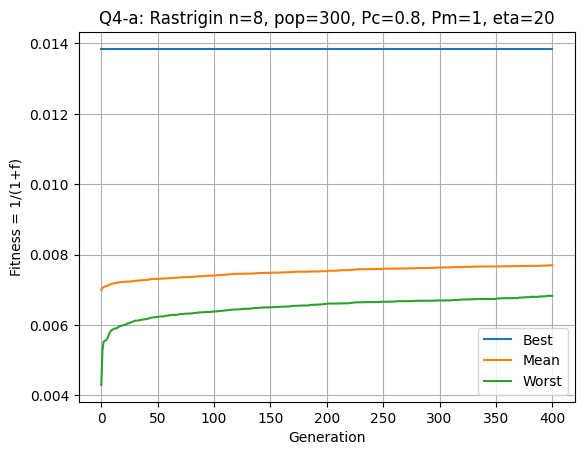

In [8]:
BASE_CFG = {
    "n": 8,
    "pop_size": 300,
    "max_generations": 400,
    "Pc": 0.8,
    "Pm": 1.0,
    "eta_mut": 20.0
}

res_a = run_ea_rastrigin(
    n=BASE_CFG["n"],
    pop_size=BASE_CFG["pop_size"],
    max_generations=BASE_CFG["max_generations"],
    Pc=BASE_CFG["Pc"],
    Pm=BASE_CFG["Pm"],
    eta_mut=BASE_CFG["eta_mut"],
    selection_type="roulette",
    random_seed=0
)

plot_evolution(
    res_a["best_history"],
    res_a["worst_history"],
    res_a["mean_history"],
    title="Q4-a: Rastrigin n=8, pop=300, Pc=0.8, Pm=1, eta=20"
)

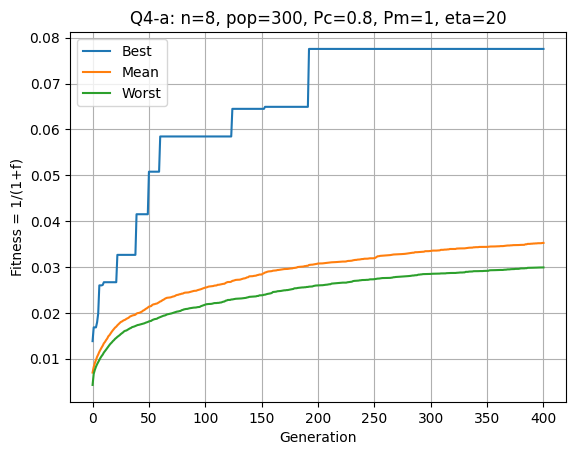

In [21]:
BASE_CFG = {
    "n": 8,
    "pop_size": 300,
    "max_generations": 400,
    "Pc": 0.8,
    "Pm": 1.0,
    "eta_mut": 20.0
}

res_a = run_ea_rastrigin(
    n=BASE_CFG["n"],
    pop_size=BASE_CFG["pop_size"],
    max_generations=BASE_CFG["max_generations"],
    Pc=BASE_CFG["Pc"],
    Pm=BASE_CFG["Pm"],
    eta_mut=BASE_CFG["eta_mut"],
    selection_type="roulette",
    random_seed=0
)

plot_evolution(
    res_a["best_history"],
    res_a["worst_history"],
    res_a["mean_history"],
    title="Q4-a: n=8, pop=300, Pc=0.8, Pm=1, eta=20"
)


### 2-
تعداد ۶ اجرای مختلف و نمودار میانگین و انحراف معیار

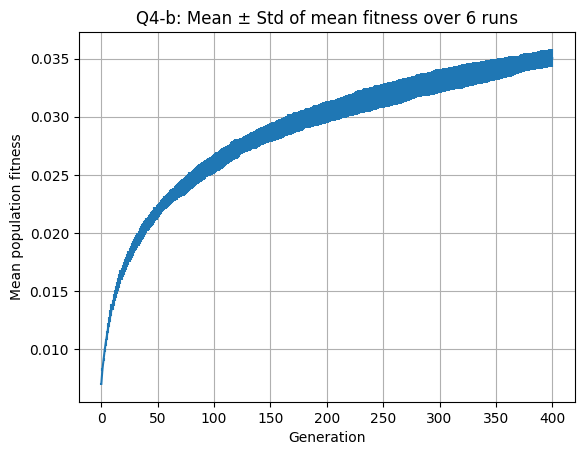

In [22]:
def multi_run_mean_history(num_runs, cfg, seed_base=100):
    mean_hist_all = []
    for r in range(num_runs):
        res = run_ea_rastrigin(
            n=cfg["n"],
            pop_size=cfg["pop_size"],
            max_generations=cfg["max_generations"],
            Pc=cfg["Pc"],
            Pm=cfg["Pm"],
            eta_mut=cfg["eta_mut"],
            selection_type="roulette",
            random_seed=seed_base + r
        )
        mean_hist_all.append(res["mean_history"])
    mean_hist_all = np.array(mean_hist_all)
    return mean_hist_all.mean(axis=0), mean_hist_all.std(axis=0)

# ===== Q4-b =====
RUNS = 6
mean_b, std_b = multi_run_mean_history(RUNS, BASE_CFG)

gens = np.arange(len(mean_b))
plt.figure()
plt.errorbar(gens, mean_b, yerr=std_b, fmt='-')
plt.xlabel("Generation")
plt.ylabel("Mean population fitness")
plt.title("Q4-b: Mean ± Std of mean fitness over 6 runs")
plt.grid(True)
plt.show()


### 3-
اثر تعداد نسل‌ها {50,100,200,300} برای هر n


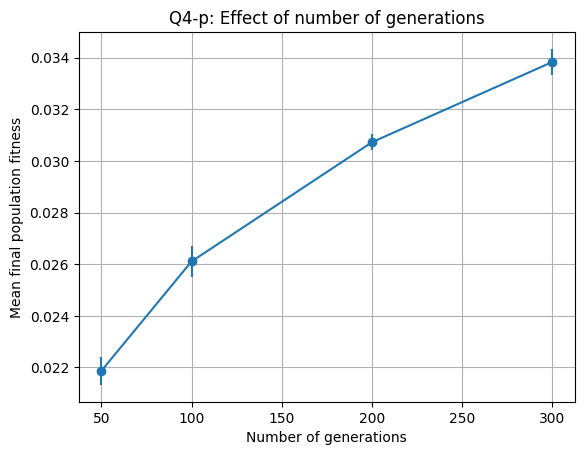

In [23]:
# ===== Q4-p: اثر تعداد تکرارهای حلقه

gen_list = [50, 100, 200, 300]
RUNS = 6

mean_final_gen = []
std_final_gen = []

for G in gen_list:
    run_means = []
    for r in range(RUNS):
        res = run_ea_rastrigin(
            n=BASE_CFG["n"],
            pop_size=BASE_CFG["pop_size"],
            max_generations=G,
            Pc=BASE_CFG["Pc"],
            Pm=BASE_CFG["Pm"],
            eta_mut=BASE_CFG["eta_mut"],
            selection_type="roulette",
            random_seed=200 + r
        )
        final_mean = float(res["final_fitnesses"].mean())
        run_means.append(final_mean)
    mean_final_gen.append(np.mean(run_means))
    std_final_gen.append(np.std(run_means))

plt.figure()
plt.errorbar(gen_list, mean_final_gen, yerr=std_final_gen, fmt='-o')
plt.xlabel("Number of generations")
plt.ylabel("Mean final population fitness")
plt.title("Q4-p: Effect of number of generations")
plt.grid(True)
plt.show()


### 4-
تأثیر اندازه جمعیت (popSize ∈ {50, 100, 200, 300})

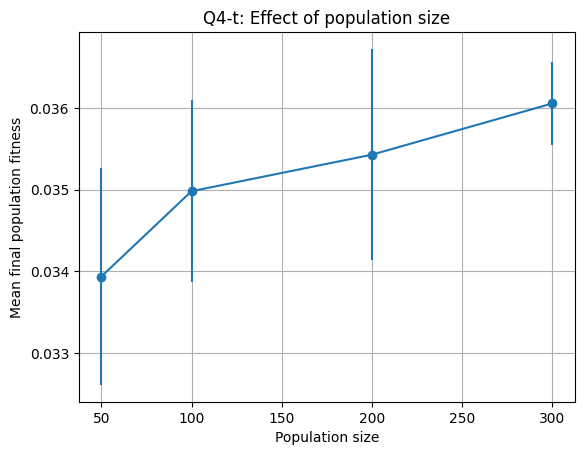

In [25]:
# ===== Q4-t: اثر اندازه جمعیت

pop_list = [50, 100, 200, 300]
RUNS = 6

mean_final_pop = []
std_final_pop = []

for P in pop_list:
    run_means = []
    for r in range(RUNS):
        res = run_ea_rastrigin(
            n=BASE_CFG["n"],
            pop_size=P,
            max_generations=BASE_CFG["max_generations"],
            Pc=BASE_CFG["Pc"],
            Pm=BASE_CFG["Pm"],
            eta_mut=BASE_CFG["eta_mut"],
            selection_type="roulette",
            random_seed=300 + r
        )
        final_mean = float(res["final_fitnesses"].mean())
        run_means.append(final_mean)
    mean_final_pop.append(np.mean(run_means))
    std_final_pop.append(np.std(run_means))

plt.figure()
plt.errorbar(pop_list, mean_final_pop, yerr=std_final_pop, fmt='-o')
plt.xlabel("Population size")
plt.ylabel("Mean final population fitness")
plt.title("Q4-t: Effect of population size")
plt.grid(True)
plt.show()


### 5-
تأثیر احتمال بازترکیب

Pc ∈ {0.6,0.7,0.9,1}


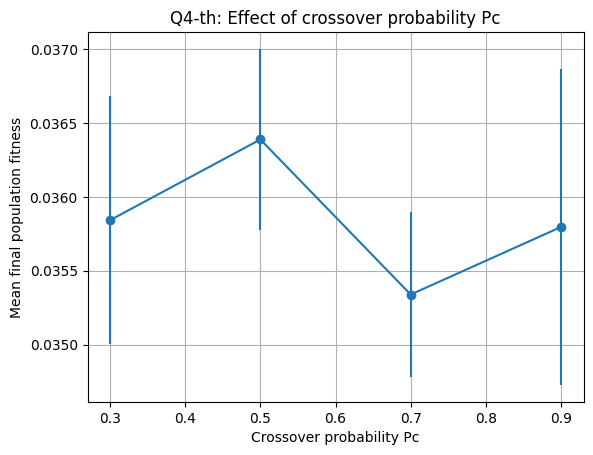

In [26]:
# ===== Q4-th: اثر احتمال بازترکیب

Pc_list = [0.3, 0.5, 0.7, 0.9]
RUNS = 6

mean_final_pc = []
std_final_pc = []

for Pc in Pc_list:
    run_means = []
    for r in range(RUNS):
        res = run_ea_rastrigin(
            n=BASE_CFG["n"],
            pop_size=BASE_CFG["pop_size"],
            max_generations=BASE_CFG["max_generations"],
            Pc=Pc,
            Pm=BASE_CFG["Pm"],
            eta_mut=BASE_CFG["eta_mut"],
            selection_type="roulette",
            random_seed=400 + r
        )
        final_mean = float(res["final_fitnesses"].mean())
        run_means.append(final_mean)
    mean_final_pc.append(np.mean(run_means))
    std_final_pc.append(np.std(run_means))

plt.figure()
plt.errorbar(Pc_list, mean_final_pc, yerr=std_final_pc, fmt='-o')
plt.xlabel("Crossover probability Pc")
plt.ylabel("Mean final population fitness")
plt.title("Q4-th: Effect of crossover probability Pc")
plt.grid(True)
plt.show()


### 6-
تأثیر احتمال جهش

Pm ∈ {0.05,0.1,0.3,0.5}

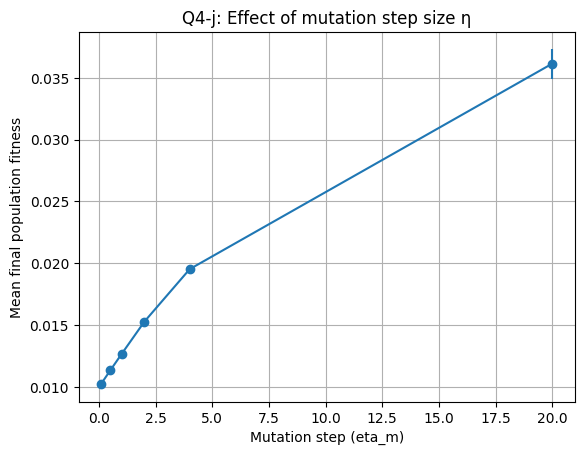

In [27]:
# ===== Q4-j: اثر گام جهش (eta_mut)

eta_list = [0.1, 0.5, 1.0, 2.0, 4.0, 20.0]
RUNS = 6

mean_final_eta = []
std_final_eta = []

for eta_mut in eta_list:
    run_means = []
    for r in range(RUNS):
        res = run_ea_rastrigin(
            n=BASE_CFG["n"],
            pop_size=BASE_CFG["pop_size"],
            max_generations=BASE_CFG["max_generations"],
            Pc=BASE_CFG["Pc"],
            Pm=BASE_CFG["Pm"],   # =1
            eta_mut=eta_mut,
            selection_type="roulette",
            random_seed=500 + r
        )
        final_mean = float(res["final_fitnesses"].mean())
        run_means.append(final_mean)
    mean_final_eta.append(np.mean(run_means))
    std_final_eta.append(np.std(run_means))

plt.figure()
plt.errorbar(eta_list, mean_final_eta, yerr=std_final_eta, fmt='-o')
plt.xlabel("Mutation step (eta_m)")
plt.ylabel("Mean final population fitness")
plt.title("Q4-j: Effect of mutation step size η")
plt.grid(True)
plt.show()


### 7-
بهترین راه‌حل برای تمام تنظیم‌ها

In [28]:
def get_best_solution_info_rastrigin(result):
    pop = result["final_population"]
    fit = result["final_fitnesses"]
    idx = np.argmax(fit)
    x_best = pop[idx]
    f_best = rastrigin(x_best)[0]
    return {
        "x_best": x_best,
        "f_best": f_best,
        "fitness": fit[idx]
    }


In [29]:
configs = []

# از بخش پ: اثر تعداد نسل
for G in gen_list:
    configs.append({
        "label": f"p_generations_{G}",
        "n": BASE_CFG["n"],
        "pop_size": BASE_CFG["pop_size"],
        "max_generations": G,
        "Pc": BASE_CFG["Pc"],
        "Pm": BASE_CFG["Pm"],
        "eta_mut": BASE_CFG["eta_mut"],
    })

# از بخش ت: اثر جمعیت
for P in pop_list:
    configs.append({
        "label": f"t_population_{P}",
        "n": BASE_CFG["n"],
        "pop_size": P,
        "max_generations": BASE_CFG["max_generations"],
        "Pc": BASE_CFG["Pc"],
        "Pm": BASE_CFG["Pm"],
        "eta_mut": BASE_CFG["eta_mut"],
    })

# از بخش ث: اثر Pc
for Pc in Pc_list:
    configs.append({
        "label": f"th_Pc_{Pc}",
        "n": BASE_CFG["n"],
        "pop_size": BASE_CFG["pop_size"],
        "max_generations": BASE_CFG["max_generations"],
        "Pc": Pc,
        "Pm": BASE_CFG["Pm"],
        "eta_mut": BASE_CFG["eta_mut"],
    })

# از بخش ج: اثر η
for eta_mut in eta_list:
    configs.append({
        "label": f"j_eta_{eta_mut}",
        "n": BASE_CFG["n"],
        "pop_size": BASE_CFG["pop_size"],
        "max_generations": BASE_CFG["max_generations"],
        "Pc": BASE_CFG["Pc"],
        "Pm": BASE_CFG["Pm"],
        "eta_mut": eta_mut,
    })

RUNS = 6
best_rows = []

for cfg in configs:
    best_overall = None
    for r in range(RUNS):
        res = run_ea_rastrigin(
            n=cfg["n"],
            pop_size=cfg["pop_size"],
            max_generations=cfg["max_generations"],
            Pc=cfg["Pc"],
            Pm=cfg["Pm"],
            eta_mut=cfg["eta_mut"],
            selection_type="roulette",
            random_seed=700 + r
        )
        info = get_best_solution_info_rastrigin(res)

        if (best_overall is None) or (info["fitness"] > best_overall["fitness"]):
            best_overall = info
            best_overall["run"] = r

    best_rows.append({
        "label": cfg["label"],
        "n": cfg["n"],
        "pop_size": cfg["pop_size"],
        "max_generations": cfg["max_generations"],
        "Pc": cfg["Pc"],
        "Pm": cfg["Pm"],
        "eta_mut": cfg["eta_mut"],
        "best_run": best_overall["run"],
        "best_fitness": best_overall["fitness"],
        "best_f_value": best_overall["f_best"],
        "best_x": best_overall["x_best"],
    })

best_df_rastrigin = pd.DataFrame(best_rows)
best_df_rastrigin

best_df_rastrigin.to_csv("EA_rastrigin_best_solutions.csv", index=False)


### 8-
تورنومنت

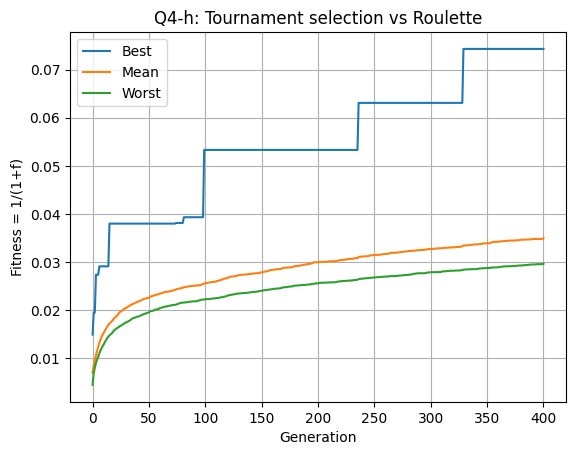

In [30]:
best_cfg = BASE_CFG.copy()

res_tourn = run_ea_rastrigin(
    n=best_cfg["n"],
    pop_size=best_cfg["pop_size"],
    max_generations=best_cfg["max_generations"],
    Pc=best_cfg["Pc"],
    Pm=best_cfg["Pm"],
    eta_mut=best_cfg["eta_mut"],
    selection_type="tournament",
    tournament_size=2,
    random_seed=999
)

plot_evolution(
    res_tourn["best_history"],
    res_tourn["worst_history"],
    res_tourn["mean_history"],
    title="Q4-h: Tournament selection vs Roulette"
)
